In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error

df = pd.read_excel('price_dataset.xlsx')
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'rate']].dropna()
df = df.groupby('date').mean().asfreq('D')
df = df.resample('MS').mean()
df.index.name = 'date'

fuel = pd.read_excel('fuel_price.xlsx', sheet_name='Table 1 Weekly', skiprows=6)
fuel.columns = ['date', 'Petrol', 'Diesel', 'Average_Price']
fuel['date'] = pd.to_datetime(fuel['date'], errors='coerce')
for col in ['Petrol', 'Diesel', 'Average_Price']:
    fuel[col] = pd.to_numeric(fuel[col], errors='coerce')
fuel = fuel.dropna()
fuel = fuel.set_index('date').resample('MS').mean()
fuel = fuel.rename(columns={'Average_Price': 'fuel_price'})

df.index = df.index.to_period('M')
fuel.index = fuel.index.to_period('M')

merged = df.merge(fuel[['fuel_price']], left_index=True, right_index=True)

#Interpolating missing values instead of dropping rows
merged['rate'] = merged['rate'].interpolate(method='linear')
merged['fuel_price'] = merged['fuel_price'].interpolate(method='linear')
merged.dropna(inplace=True)  # optional safeguard

train = merged.iloc[:-6]
test = merged.iloc[-6:]


In [8]:
merged.head(10)  # Shows the first 10 rows of the merged dataset

,rate,fuel_price
date,,
2021-02,1.106204,68.342064
2021-03,1.522375,98.353350
2021-04,1.803217,240.699325
2021-05,1.892810,180.959763
2021-06,2.048666,134.734564
2021-07,2.293186,113.580290
2021-08,2.130193,103.655959
2021-09,1.884101,109.562584
2021-10,1.553814,102.348267


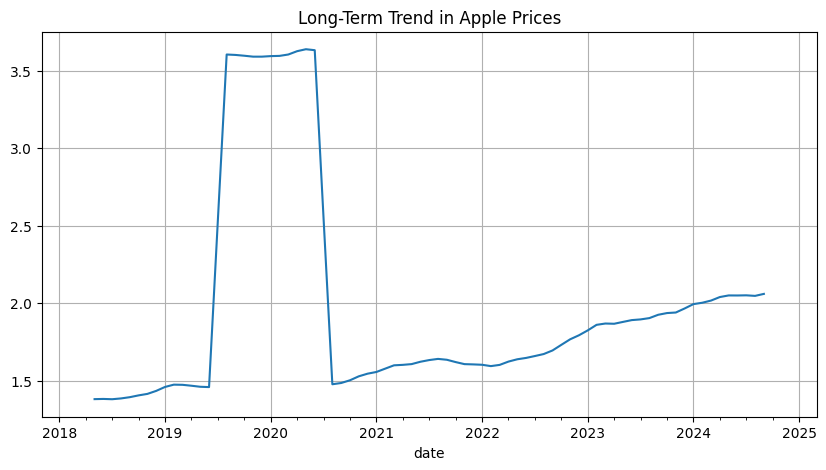

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposition = seasonal_decompose(df['rate'], model='additive', period=12)
decomposition.trend.plot(title="Long-Term Trend in Apple Prices", figsize=(10, 5))
plt.grid(True)
plt.show()


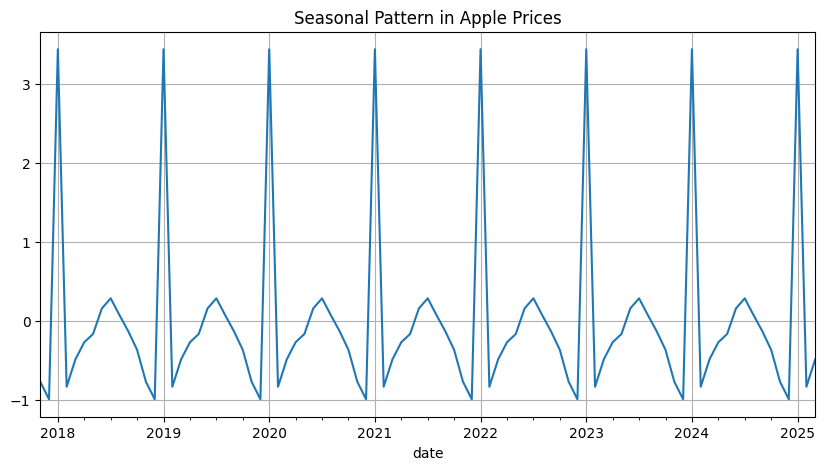

In [10]:
decomposition.seasonal.plot(title="Seasonal Pattern in Apple Prices", figsize=(10, 5))
plt.grid(True)
plt.show()


In [11]:
correlation = merged['rate'].corr(merged['fuel_price'])
print("Correlation between fuel price and apple price:", round(correlation, 3))


Correlation between fuel price and apple price: -0.058


In [13]:
# Interpolate missing values instead of dropping them
merged[['rate', 'fuel_price']] = merged[['rate', 'fuel_price']].interpolate(method='linear')

# Run Granger causality test
from statsmodels.tsa.stattools import grangercausalitytests

# Now the data has no missing values, but still maintains time structure
granger_results = grangercausalitytests(merged[['rate', 'fuel_price']], maxlag=4, verbose=False)

# Print p-values for each lag
for lag in granger_results:
    print(f"Lag {lag}, P-Value: {granger_results[lag][0]['ssr_ftest'][1]}")


Lag 1, P-Value: 0.7751399633012889
Lag 2, P-Value: 0.6303981031272929
Lag 3, P-Value: 0.7642214386535036
Lag 4, P-Value: 0.307139243824368


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


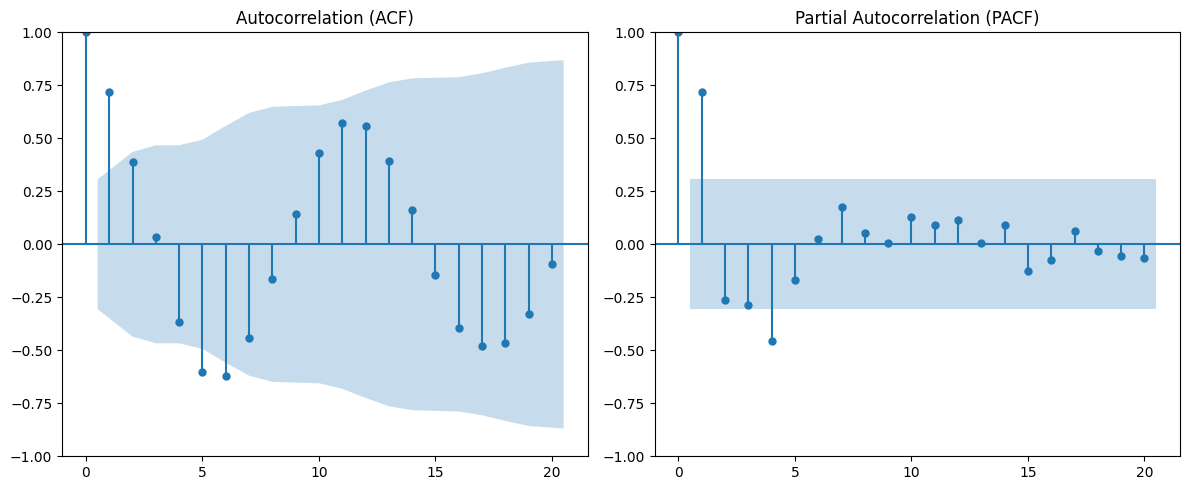

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(train['rate'], lags=20, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(train['rate'], lags=20, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()


In [14]:
# ARIMA Model (Univariate)
arima_model = ARIMA(train['rate'], order=(1,1,1)).fit()
arima_forecast = arima_model.forecast(6)
arima_rmse = np.sqrt(mean_squared_error(test['rate'], arima_forecast))

# ARIMAX Model (Multivariate with fuel price)
arimax_model = ARIMA(train['rate'], exog=train[['fuel_price']], order=(1,1,1)).fit()
arimax_forecast = arimax_model.forecast(6, exog=test[['fuel_price']])
arimax_rmse = np.sqrt(mean_squared_error(test['rate'], arimax_forecast))

# SARIMA Model
sarima_model = SARIMAX(train['rate'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(6)
sarima_rmse = np.sqrt(mean_squared_error(test['rate'], sarima_forecast))

# SARIMA (Tuned)
sarima2_model = SARIMAX(train['rate'], order=(2,1,2), seasonal_order=(2,1,1,12)).fit()
sarima2_forecast = sarima2_model.forecast(6)
sarima2_rmse = np.sqrt(mean_squared_error(test['rate'], sarima2_forecast))

# Holt-Winters Model
hw_model = ExponentialSmoothing(train['rate'], trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(6)
hw_rmse = np.sqrt(mean_squared_error(test['rate'], hw_forecast))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


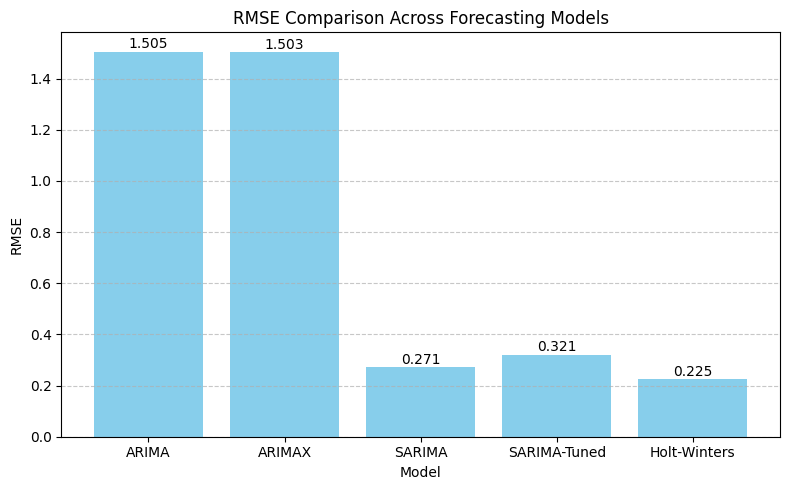

In [ ]:
# RMSE Bar Chart
models = ['ARIMA', 'ARIMAX', 'SARIMA', 'SARIMA-Tuned', 'Holt-Winters']
rmse_scores = [arima_rmse, arimax_rmse, sarima_rmse, sarima2_rmse, hw_rmse]

plt.figure(figsize=(8,5))
bars = plt.bar(models, rmse_scores, color='skyblue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.002, round(yval, 3), ha='center', va='bottom')

plt.title("RMSE Comparison Across Forecasting Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


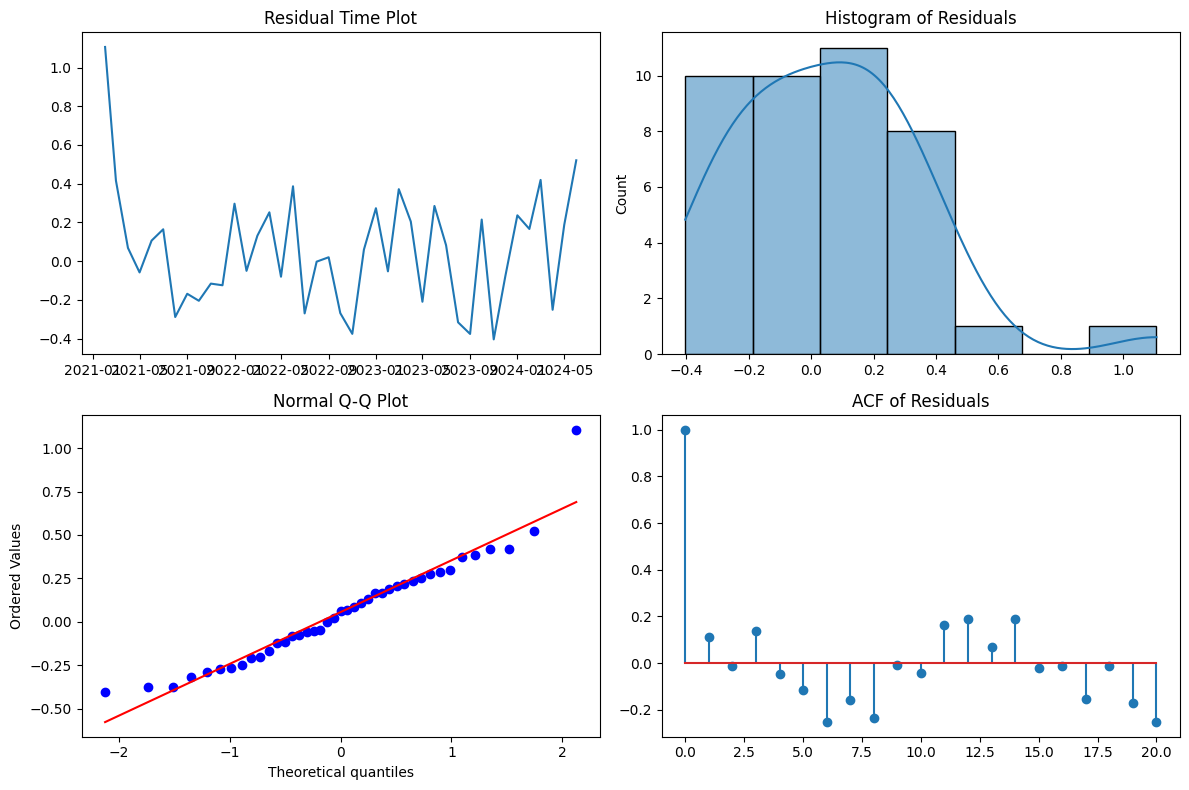

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Fit ARIMA model
model = ARIMA(train['rate'], order=(1, 1, 1))
model_fit = model.fit()
residuals = model_fit.resid

# ✅ Fix: Convert index for plotting
residuals.index = residuals.index.to_timestamp()

# Plot diagnostics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1. Residual Time Plot
axs[0, 0].plot(residuals)
axs[0, 0].set_title('Residual Time Plot')

# 2. Histogram
sns.histplot(residuals, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Residuals')

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Normal Q-Q Plot')

# 4. ACF of Residuals
acf_vals = acf(residuals, fft=False, nlags=20)
axs[1, 1].stem(range(len(acf_vals)), acf_vals)
axs[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.savefig("residual_diagnostics.png")
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyk9sbhst/a1_cx88g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyk9sbhst/eoh21ty7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81696', 'data', 'file=/tmp/tmpyk9sbhst/a1_cx88g.json', 'init=/tmp/tmpyk9sbhst/eoh21ty7.json', 'output', 'file=/tmp/tmpyk9sbhst/prophet_modelq87du_cc/prophet_model-20250422114734.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:47:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

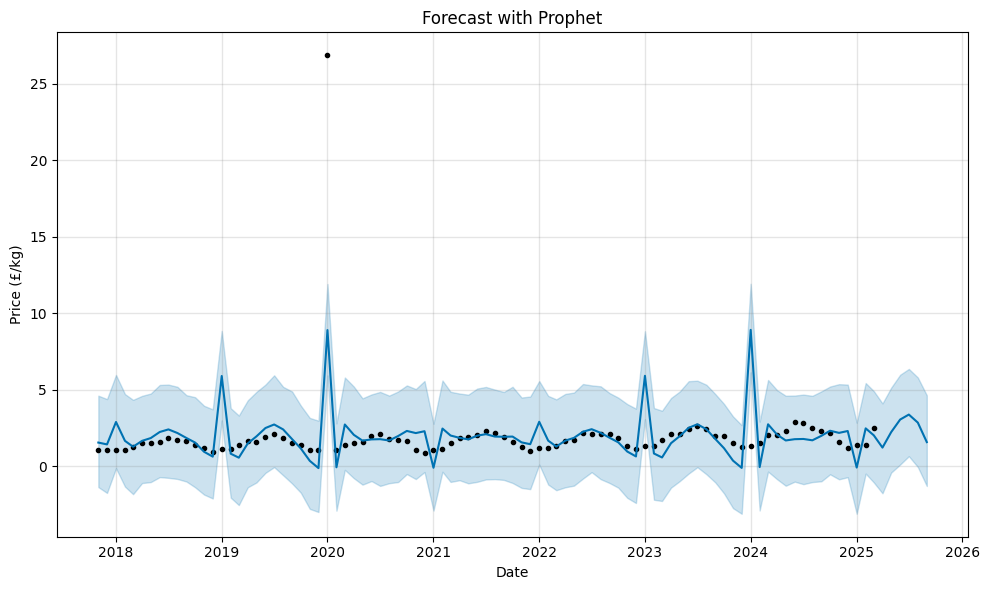

In [ ]:

# Convert index to datetime for Prophet
df_prophet = df.copy()
df_prophet.index = df_prophet.index.to_timestamp()  # <-- FIX applied here

# Prepare dataframe for Prophet
prophet_df = df_prophet.reset_index().rename(columns={'date': 'ds', 'rate': 'y'})

# Train and forecast
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)

# Plot
fig = prophet_model.plot(forecast)
plt.title("Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("Price (£/kg)")
plt.grid(True)
plt.tight_layout()
plt.show()


Solution to Optimization

In [ ]:
!pip install pulp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.1 MB/s eta 0:00:00


In [ ]:
print(supply_chain_df.columns.tolist())


['Product type', 'SKU', 'Price', 'Availability', 'Number of products sold', 'Revenue generated', 'Customer demographics', 'Stock levels', 'Lead times', 'Order quantities', 'Shipping times', 'Shipping carriers', 'Shipping costs', 'Supplier name', 'Location', 'Lead time', 'Production volumes', 'Manufacturing lead time', 'Manufacturing costs', 'Inspection results', 'Defect rates', 'Transportation modes', 'Routes', 'Costs']


In [ ]:
import pandas as pd

# Assuming you already loaded the CSV:
supply_chain_df = pd.read_csv('supply_chain_data.csv')

# Construct a minimal DataFrame with relevant fields
df = pd.DataFrame({
    'Supplier': supply_chain_df['Supplier name'],
    'Warehouse': supply_chain_df['Location'],
    'Transport_cost': supply_chain_df['Costs'],
    'Manufacturing_cost': supply_chain_df['Manufacturing costs'],
    'Demand': supply_chain_df['Order quantities'],       # Assumed proxy
    'Supply': supply_chain_df['Production volumes']      # Assumed proxy
}).dropna()

# Add Total Cost column
df['Total_cost'] = df['Transport_cost'] + df['Manufacturing_cost']

df.head()


,Supplier,Warehouse,Transport_cost,Manufacturing_cost,Demand,Supply,Total_cost
0,Supplier 3,Mumbai,187.752075,46.279879,96,215,234.031955
1,Supplier 3,Mumbai,503.065579,33.616769,37,517,536.682348
2,Supplier 1,Mumbai,141.920282,30.688019,88,971,172.608301
3,Supplier 5,Kolkata,254.776159,35.624741,59,937,290.400901
4,Supplier 1,Delhi,923.440632,92.065161,56,414,1015.505792


Defining Decision Variables

In [ ]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

decision_vars = {
    (row['Supplier'], row['Warehouse']): LpVariable(f"x_{row['Supplier']}_{row['Warehouse']}", lowBound=0, cat='Continuous')
    for _, row in df.iterrows()
}


 Define Objective Function

In [ ]:
model = LpProblem("Supply_Chain_Cost_Minimization", LpMinimize)

model += lpSum(
    decision_vars[(row['Supplier'], row['Warehouse'])] * row['Total_cost']
    for _, row in df.iterrows()
)


Add Constraints
Supply constraints:

In [ ]:
for s in df['Supplier'].unique():
    model += lpSum(
        decision_vars[(row['Supplier'], row['Warehouse'])]
        for _, row in df[df['Supplier'] == s].iterrows()
    ) <= df[df['Supplier'] == s]['Supply'].iloc[0], f"Supply_Constraint_{s}"


Demand constraints:

In [ ]:
for w in df['Warehouse'].unique():
    model += lpSum(
        decision_vars[(row['Supplier'], row['Warehouse'])]
        for _, row in df[df['Warehouse'] == w].iterrows()
    ) >= df[df['Warehouse'] == w]['Demand'].iloc[0], f"Demand_Constraint_{w}"


 Solve the Model

In [ ]:
model.solve()


1

 Extract and Display Results

In [ ]:
solution = []
for key, variable in decision_vars.items():
    if variable.varValue > 0:
        supplier, warehouse = key
        unit_cost = df[(df['Supplier'] == supplier) & (df['Warehouse'] == warehouse)]['Total_cost'].values[0]
        solution.append({
            'Supplier': supplier,
            'Warehouse': warehouse,
            'Units Shipped': variable.varValue,
            'Unit Cost': unit_cost,
            'Total Cost': variable.varValue * unit_cost
        })

import pandas as pd
solution_df = pd.DataFrame(solution)
total_cost = value(model.objective)

print("Optimised Shipment Plan:")
print(solution_df)
print(f"\nTotal Minimum Cost: {total_cost:.2f}")


Optimised Shipment Plan:
     Supplier  Warehouse  Units Shipped    Unit Cost    Total Cost
0  Supplier 3     Mumbai      32.000000   234.031955   7489.022550
1  Supplier 3    Kolkata      19.666667   135.454165   2663.931965
2  Supplier 2    Chennai      27.666667  1043.887063  28880.875761
3  Supplier 1  Bangalore      13.200000   224.983082   2969.776679
4  Supplier 3      Delhi      28.000000   175.411750   4911.529009

Total Minimum Cost: 156273.96


Total Units Shipped by Supplier

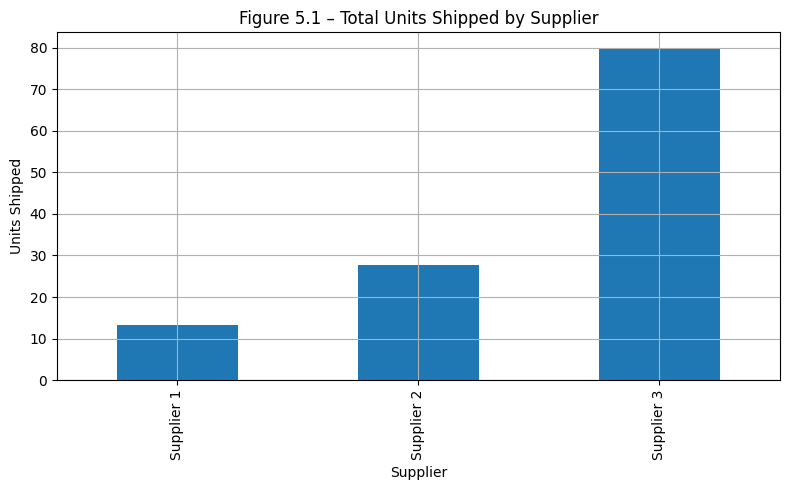

In [ ]:
# Total Units Shipped by Supplier
import matplotlib.pyplot as plt

supplier_summary = solution_df.groupby('Supplier')['Units Shipped'].sum()
supplier_summary.plot(kind='bar', figsize=(8,5), title="Figure 5.1 – Total Units Shipped by Supplier")
plt.xlabel("Supplier")
plt.ylabel("Units Shipped")
plt.grid(True)
plt.tight_layout()
plt.show()


Total Supply Cost per Warehouse

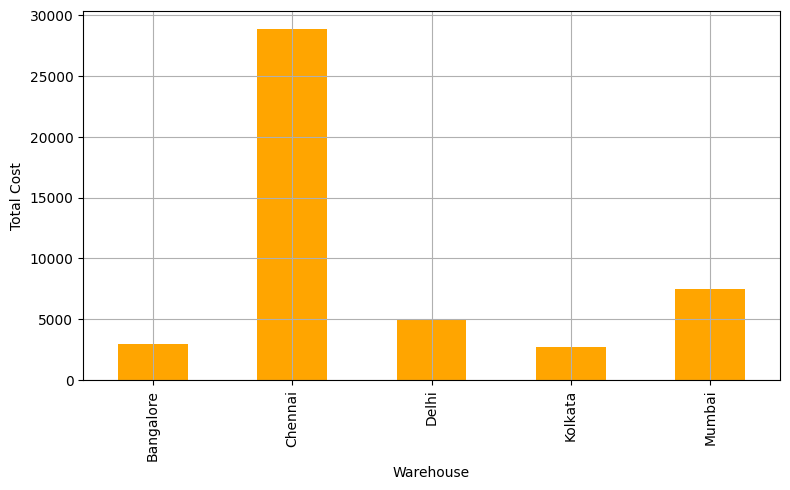

In [ ]:
# Total Supply Cost per Warehouse
warehouse_costs = solution_df.groupby('Warehouse')['Total Cost'].sum()
warehouse_costs.plot(kind='bar', color='orange', figsize=(8,5))
plt.xlabel("Warehouse")
plt.ylabel("Total Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


Methodlogy Flowchart

In [ ]:
!pip install graphviz

In [ ]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='Methodology Flowchart')
dot.attr(rankdir='TB', size='8')

# Add nodes
dot.node('A', 'Data Collection')
dot.node('B', 'Data Preprocessing & EDA')
dot.node('C', 'Time-Series Decomposition')
dot.node('D', 'Stationarity & Differencing')
dot.node('E', 'Model Development')
dot.node('F', 'Model Evaluation')
dot.node('G', 'Business Insight Generation')

# Add edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG'])

# Render
dot.render('methodology_flowchart', format='png', cleanup=True)
dot.view()


'methodology_flowchart.pdf'